# Label Propagation

# Outline   
* Uses a rule-based approach to identify areas with high confidence of a certain label. This method is used to gather 2,000 labeled points. 
* Another 2,000 unlabeled points are gathered within the country extent but outside of the high confidence areas.
* The labeled data is first used to train a logistic regression model.
* The labeled and unlabeled data are combined and fed into a Label Propagation algorithm. Expect the semi-supervised learning algorithm to outperform the logistic regression model, which is fit on the labeled data alone.


### Create Labeled Points
#### Create High Confidence Polygons
* this will create high confidence polygons from the overlay of the input datasets and extract the centroid of each geometry

### Create Unlabeled Points
#### Gather Unlabeled Points
* `get_unlabeled_pts()`

### Prepare Data

#### Transform Points to Grids
* `convert_centroid_to_grid()`
* `calc_grid()`
* QAQC on how well the grid overlays on high confidence polygons and how to handle outsider points, then develop approach for labeling outsider points.

#### Prepare Datasets
* `sentinel_merge_and_clip()`
* `reproject()`  
* eventually download sentinel tiles for input country

#### Extract Raster Values
* `get_features()` 
* `clean_features()` 
* Consider some sort of QAQC of the labeled and unlabeled points?
* Consider how well extract raster values aligns with the high conf values?

### Label Propagation
#### Prepare Model Input
* `workflow established`

#### Supervised Learning: Logistic Regression
* `workflow established`

#### Semi-Supervised Learning: Label Propagation
* `workflow established`

# Code

In [1]:
#from shapely.geometry import Point, Polygon
import geopandas as gpd
import requests
from tqdm.auto import tqdm
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import rasterio as rs
from rasterio.mask import mask
from rasterio.merge import merge
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from glob import glob
import os
import rasterio as rs
import shapely
import shapely.vectorized
from shapely.geometry import Point
from datetime import datetime
from typing import Tuple
import math

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

## Create Labeled Points

### Create High Confidence Polys

In [4]:
def create_highconf_polygons():
    '''
    Inputs:
        - National Land Use Land Cover map
        - Tropical Tree Cover
        - Spatial Database of Planted Trees
        - GADM National Boundary
    
    Objective: extract "high confidence" areas where the input datasets have overlap.
    
    Rules: see ppt
    
    Harmonization Steps:
        1. Assert all inputs use the same crs. Reproject if necessary.
        2. Assert all inputs have the same resolution. Resample if necessary.
        3. Get the extent of all rasters, intersect extent and make windows.
        4. Create high confidence polygons based on overlap of all datasets.
        5. Extract the centroid of the polygon
        
    https://gis.stackexchange.com/questions/447158/getting-the-intersection-of-two-raster-files-using-pandas-python
    
    '''

## Create Unlabeled Points

### Gather Unlabeled Points

In [87]:
def get_unlabeled_pts(country, high_conf, num_pts):
    
    '''
    Points must fall within the country bounds but outside of
    the high confidence areas.
    Warning: overlay could take some time to process. Use sparingly 
    and save output.
    '''
    #over = gpd.read_file(f'../data/label_prop/costa_rica/hc_overlay.shp')
    start = datetime.now()
    over = gpd.overlay(country, high_conf, 'difference', keep_geom_type=True)
    over.to_file(f'../data/label_prop/costa_rica/hc_overlay.shp')
    end = datetime.now()
    print(end - start)
    
    df = pd.DataFrame()
    
    minx = over.bounds.minx[0]
    miny = over.bounds.miny[0]
    maxx = over.bounds.maxx[0]
    maxy = over.bounds.maxy[0]
    
    # bounds are the same
    print(minx, miny, maxx, maxy)
    print(country.bounds.minx[0], country.bounds.miny[0], country.bounds.maxx[0], country.bounds.maxy[0])

    x = np.random.uniform(minx, maxx, num_pts)
    y = np.random.uniform(miny, maxy, num_pts)
    df['geometry'] = [Point(xy) for xy in zip(x,y)]
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
   
    
    return gdf

def get_unlabeled_pts_while(country, high_conf, num_pts):
    
    
    valid = pd.DataFrame()
    
    while len(valid) < num_pts:
        minx = country.bounds.minx[0]
        miny = country.bounds.miny[0]
        maxx = country.bounds.maxx[0]
        maxy = country.bounds.maxy[0]
        x = np.random.uniform(minx, maxx, num_pts)
        y = np.random.uniform(miny, maxy, num_pts)

        # turn points into geodataframe to identify invalids
        df = pd.DataFrame()
        df['geometry'] = [Point(xy) for xy in zip(x,y)]
        gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
        invalid = gpd.sjoin(gdf, high_conf, predicate = 'within')
        df = df.drop(invalid.index)
        pd.concat([df, valid])
        
    return valid

In [88]:
valid = get_unlabeled_pts_while(country, hc, 10)

/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/jessica.ertel/opt/anaconda3/envs/planta

/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/jessica.ertel/opt/anaconda3/envs/planta

KeyboardInterrupt: 

In [79]:
valid

,geometry
0,POINT (-83.50493255236918 10.762198875067803)
1,POINT (-85.38566471910994 9.41242766659845)
2,POINT (-83.82165666241157 10.905466422510955)
3,POINT (-83.82444900287297 9.435727519327429)
4,POINT (-83.41146910263112 10.906632661085439)
5,POINT (-84.96542353135344 10.015331908125207)
6,POINT (-83.69814118121317 9.379008589227848)
7,POINT (-85.35239836141086 9.26410859953175)
8,POINT (-85.88226035364403 10.487822060657368)
9,POINT (-83.28016230541361 9.952458096548545)


In [80]:
invalid

,geometry,index_right,Id,gridcode,Area,LULC,MERGE_SRC,Shape_Leng,Shape_Area,PClass


In [63]:
unlabeled.index

Int64Index([630, 1010, 1692], dtype='int64')

In [4]:
folder = ('../data/label_prop/')
country = gpd.read_file(f'{folder}/costa_rica/gadm41_CRI_0_clipped.shp')
hc = gpd.read_file(f'{folder}HighConf_poly1.shp')
cr = gpd.read_file(f'{folder}/costa_rica/gadm41_CRI_0_clipped.shp')
over = gpd.read_file(f'../data/label_prop/costa_rica/hc_overlay.shp')
labeled = gpd.read_file(f'{folder}/HighConf_Point.shp')

In [68]:
unlabeled = get_unlabeled_pts(country, hc, 2000)

0:06:52.549699
-85.97906899999992 8.039627318000043 -82.55231898799997 11.219757893000178
-85.97906899999992 8.039627318000043 -82.55231898799997 11.219757893000178


/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [56]:
difference = country.difference(hc)
print(time.time())
overlay = gpd.overlay(country, hc, 'difference', keep_geom_type=True)
overlay.to_file(f'../data/label_prop/costa_rica/hc_overlay.shp')
print(time.time())

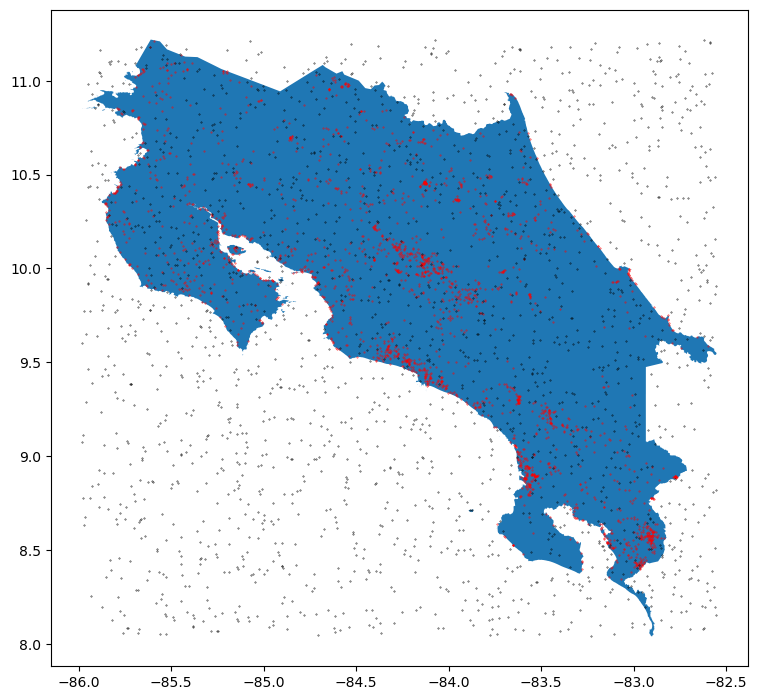

In [69]:
ax = cr.plot(figsize=(6,6))
labeled.plot(ax=ax, color='red', markersize=0.1)
unlabeled.plot(ax=ax, color='black', markersize=0.1);

## Prepare Datasets

### Transform Points to Grid

In [19]:
def calc_grid(minx, maxx, miny, maxy, grid_res = 10):
    
    '''
    Buffer is a df column that contains a polygon
    form the grid by setting up the coordinates and then fill grid with numpy.meshgrid
    adding half the grid_res to the maxx (or maxy) value ensures the end point is 
    included in the range
    '''
    x = np.arange(minx, maxx + grid_res / 2, grid_res)
    y = np.arange(miny, maxy + grid_res / 2, grid_res)
    xx, yy = np.meshgrid(x, y)

    # flatten points to 1D vectors
    x_in_buff = xx.ravel()
    y_in_buff = yy.ravel()
    
    return list(zip(x_in_buff, y_in_buff))


def convert_centroid_to_grid(df, to_crs, radius = 65):
    
    '''
    Converts a lat/lon centroid into a 14x14 grid of points
    with 10m spacing by buffering the point with a radius and
    using the bounding box to determine the location of 
    points. Returns a geodataframe with the original centroid,
    buffer and 14x14 point grid.
    65 meters will place each point as the centroid of the 10m pixel
    
    TODO: Confirm if crs will vary by country
    '''
    # reproject from degrees to metric coordinate system 
    df = df[['geometry']].to_crs(epsg=to_crs)

    df['buffer'] = df['geometry'].buffer(radius, cap_style=3)
    df['minx'] = df['buffer'].bounds.minx
    df['maxx'] = df['buffer'].bounds.maxx
    df['miny'] = df['buffer'].bounds.miny
    df['maxy'] = df['buffer'].bounds.maxy
    
    df['grid'] = df.apply(lambda x: calc_grid(x['minx'], x['maxx'], x['miny'], x['maxy']), axis=1)
    
    return df[['geometry', 'buffer', 'grid']]    

In [22]:
folder = ('../data/label_prop/')
labeled_pts = gpd.read_file(f'{folder}/HighConf_Point.shp')
labeled_grid = convert_centroid_to_grid(labeled_pts, to_crs=3857)

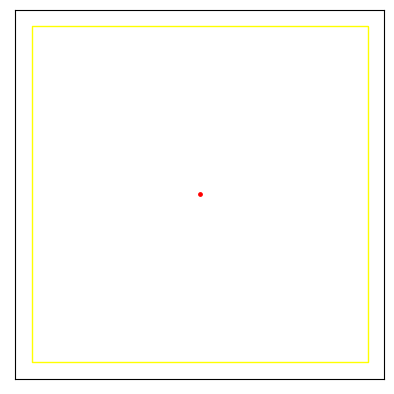

In [23]:
# visualize grid, original buffer zone and centroid
ax = labeled_grid.loc[[0], 'geometry'].plot(markersize=6, color='red')
labeled_grid.loc[[0], 'buffer'].plot(color='none', edgecolor='yellow', ax=ax)
#plt.scatter(x_in_buff, y_in_buff, s=0.4)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False);

### Prepare Datasets

In [24]:
# Mosaic sentinel files then clip to Costa Rica boundary

def sentinel_merge_and_clip(country, data):
    
    folder = (f'../data/label_prop/{country}/')

    # now open each item in dataset reader mode (required to merge)
    reader_mode = []

    for file in glob(f'{folder}{data}/*.tif'):
        src = rs.open(file)
        reader_mode.append(src) 

    # for s2 and s1 nodata value is 0
    mosaic, out_transform = merge(reader_mode)
    
    # outpath will be the new filename
    merged = f'{folder}{country + data}_merged.tif'
    out_meta = src.meta.copy()  
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint16',  
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform,
                     'compress':'lzw'})

    with rs.open(merged, "w", **out_meta, BIGTIFF='YES') as dest:
        dest.write(mosaic)

    # now clip merged tif to country boundaries
    merged = f'{folder}{country + data}_merged.tif'
    shapefile = gpd.read_file(f'{folder}gadm41_CRI_0.shp')
    clipped = f'{folder}{country + data}_clipped.tif'

    with rs.open(merged) as src:
        shapefile = shapefile.to_crs(src.crs)
        out_image, out_transform = mask(src, shapefile.geometry, crop=True)
        out_meta = src.meta.copy() 

    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })

    with rs.open(clipped,'w',**out_meta, BIGTIFF='YES') as dst:
        dst.write(out_image)
    
    print(f'{len(reader_mode)} tifs merged and clipped to {country}.')
    os.remove(merged)
    return None

In [28]:
merge_and_clip('costa_rica', 's1')

13 tifs merged and clipped to costa_rica.


In [29]:
merge_and_clip('costa_rica', 's2')

13 tifs merged and clipped to costa_rica.


In [6]:
## reproject the lulc dataset to espg 4326 to match other input data
## taken verbatim from rasterio documentation w/ added compression params

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rs.open('../data/testing/lulc_cr.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'lzw',
        'dtype': 'uint8'})

    with rs.open('../data/testing/lulc_cr_reprj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rs.band(src, i),
                destination=rs.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

## Extract Raster Values

In [20]:
def get_features(pts):
    
    '''
    Extracts features for each point from the imported raster and vector
    datasets. Returns dataframe where each row
    represents an unlabeled observation.
    
    Even though lulc, sdpt and ttc values are not needed for unlabeled data
    they are extracted for the validation phase.
    
    if there is no sentinel 1 or 2 data, drop the sample
    no s1 bc of terrain shadow and no s2 bc of clouds

    '''

    # import ttc, sdpt and lulc data and confirm crs
    ttc = rs.open('../data/label_prop/costa_rica/CostaRica.tif')
    sdpt = gpd.read_file('../data/label_prop/cri_sdpt_v2.shp')
    lulc = rs.open('../data/label_prop/lulc_cr_reprj.tif')
    s1 = rs.open(f'{folder}/costa_rica/costa_ricas1_clipped.tif')
    s2 = rs.open(f'{folder}/costa_rica/costa_ricas2_clipped.tif')
    
    assert ttc.crs == sdpt.crs == lulc.crs == s1.crs == s2.crs == pts.crs
    
    coords = [(x,y) for x, y in zip(pts.geometry.x, pts.geometry.y)]
    
    # create new df to hold extracted attributes
    pts['point_x'] = pts.geometry.x
    pts['point_y'] = pts.geometry.y
    pts['ttc'] = [x[0] for x in ttc.sample(coords)]
    pts['lulc'] = [x[0] for x in lulc.sample(coords)]
    pts['s1'] = [x[0] for x in s1.sample(coords)]
    pts['s2'] = [x[0] for x in s2.sample(coords)]
    
    # for sdpt must perform a join before extraction
    intersection = gpd.sjoin(pts, sdpt[['originalCo', 'originalNa', 'geometry']], how='left', predicate='within')
    pts['sdpt'] = intersection['originalCo']
    
    return pts


def clean_features(pts, labels, sample):
    '''
    Applies some cleaning steps and drops poor quality training samples.
    Option to sample the dataset to balance classes
    TODO: address hard coding of sample count
    
    '''
    
    # turn lulc values into categories
    pts['lulc'] = pts['lulc'].map({7: 'forest plantation', 
                                8: 'mature forest', 
                                9: 'bare', 
                                10: 'urban', 
                                14: 'mangrove',
                                20: 'palm',
                                22: 'pineapple', 
                                23: 'coffee', 
                                30: 'water'})
    
    # turn sdpt values into categories
    pts['sdpt'] = pts['sdpt'].map({2.0: 'forest plantation', 
                                   1.0: 'oil palm', 
                                   7215.0: 'orchard'})
    
    # fix incorrect labels for forest plantations 
    # only do this step if importing kanchanas data
    condition = pts.sdpt == 'forest plantation'
    pts.loc[condition, 'label'] = 'monoculture'
    
    no_sentinel = pts[(pts.s1 == 0.0) & (pts.s2 == 0.0)]
    no_data = pts[(pts.sdpt == 'nan')&(pts.ttc == '255')&(pts.lulc == '255')].index
    
    pts = pts[(pts.s1 != 0.0)]
    pts = pts[pts.s2 != 0.0]
    pts = pts.drop(no_data)
    #pts = pts[~no_data]
    
    print(f'{len(no_sentinel)} samples have no sentinel values.')
    print(f'{len(no_data)} samples have no data values.')
    print(f'{len(no_sentinel)+len(no_data)} samples will be dropped.')
    
    if labels:
        pts['label'] = pts['label'].map({'notplantation': 0, 'monoculture': 1, 'agroforestry': 2})
        if sample:
            sample0 = pts[pts.label == 0].sample(95, random_state=22)
            sample1 = pts[pts.label == 1].sample(95, random_state=22)
            sample2 = pts[pts.label == 2].sample(95, random_state=22)
            pts = pd.concat([sample2, sample1, sample0])
            
    else:
        pts['label'] = -1
        if sample:
            pts = pts.sample(275, random_state=22)
    
    pts[['lulc', 'sdpt', 'ttc']] = pts[['lulc', 'sdpt', 'ttc']].astype(str)
    
    print(f'{len(pts)} total samples with class distribution:') 
    print(f'{round(pts.label.value_counts(normalize=True),2)}')

    return pts

## EDA

In [13]:
# # quick visual to get a sense of the location of labeled and unlabeled points
# ax = cr.plot(figsize=(6,6))
# labeled.plot(ax=ax, color='red', markersize=0.1)
# unlabeled.plot(ax=ax, color='black', markersize=0.1);

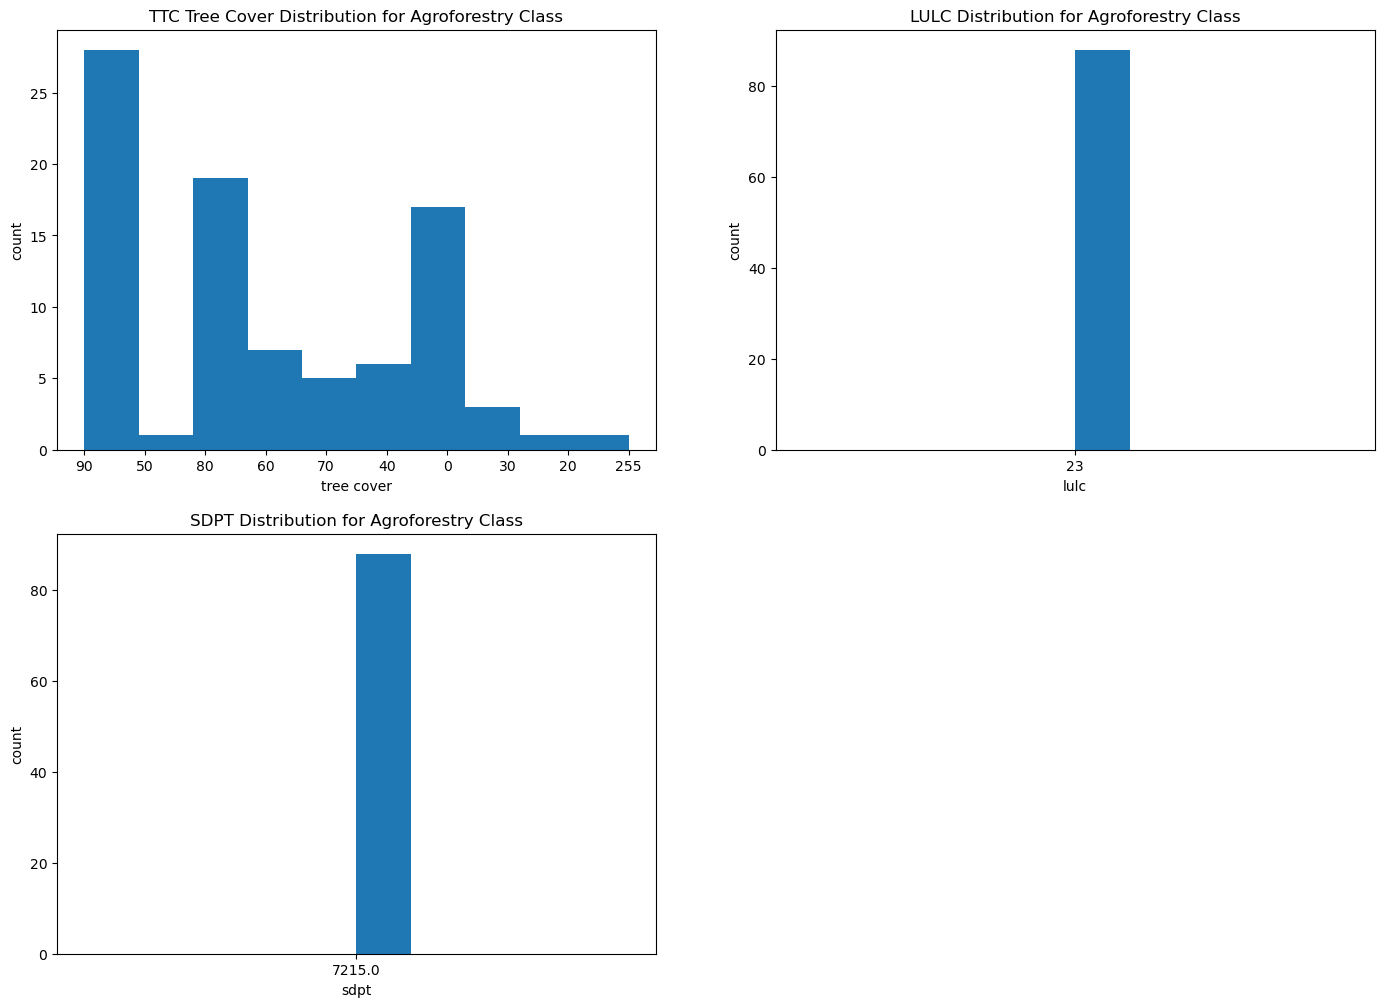

In [41]:
plt.figure(figsize=(17,12)) 

plt.subplot(2,2,1)
plt.hist(labeled[labeled.label == '2'].ttc)
plt.xlabel('tree cover')
plt.ylabel('count')
plt.title('TTC Tree Cover Distribution for Agroforestry Class')

plt.subplot(2,2,2)
plt.hist(labeled[labeled.label == '2'].lulc)
plt.xlabel('lulc')
plt.ylabel('count')
plt.title('LULC Distribution for Agroforestry Class')

plt.subplot(2,2,3)
plt.hist(labeled[labeled.label == '2'].sdpt)
plt.xlabel('sdpt')
plt.ylabel('count')
plt.title('SDPT Distribution for Agroforestry Class');

In [56]:
# what would confidence scores look like
low = labeled[(labeled.ttc == '255')&(labeled.sdpt == 'nan')]
med = labeled[(labeled.ttc == '255')&(labeled.sdpt != 'nan')]
print(f'low confidence samples: {len(low)}')
print(f'med confidence samples: {len(med)}')
print(f'high confidence samples: {len(labeled)-len(low)-len(med)}')

low confidence samples: 22
med confidence samples: 3
high confidence samples: 2064


## Label Propagation

### Prepare Model Input

In [24]:
folder = ('../data/label_prop/')
cr = gpd.read_file(f'{folder}/costa_rica/gadm41_CRI_0_clipped.shp')
hc_poly = gpd.read_file(f'{folder}HighConf_poly1.shp')

unlabeled_pts = gpd.read_file(f'{folder}/output_unlabelledPts.shp')
labeled_pts = gpd.read_file(f'{folder}/HighConf_Point.shp')
labeled_pts = labeled_pts[['geometry', 'label']]

In [25]:
labeled = get_features(labeled_pts)
labeled = clean_features(labeled_pts, labels=True, sample=False)
display(labeled.info())

105 samples have no sentinel values.
0 samples have no data values.
105 samples will be dropped.
2089 total samples with class distribution:
0    0.65
1    0.31
2    0.04
Name: label, dtype: float64
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2089 entries, 0 to 2193
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  2089 non-null   geometry
 1   label     2089 non-null   int64   
 2   point_x   2089 non-null   float64 
 3   point_y   2089 non-null   float64 
 4   ttc       2089 non-null   object  
 5   lulc      2089 non-null   object  
 6   s1        2089 non-null   uint16  
 7   s2        2089 non-null   uint16  
 8   sdpt      2089 non-null   object  
dtypes: float64(2), geometry(1), int64(1), object(3), uint16(2)
memory usage: 138.7+ KB


None

In [26]:
unlabeled = get_features(unlabeled_pts)
unlabeled = clean_features(unlabeled_pts, labels=False, sample=False)
display(unlabeled.info())

0 samples have no sentinel values.
0 samples have no data values.
0 samples will be dropped.
1994 total samples with class distribution:
-1    1.0
Name: label, dtype: float64
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1994 entries, 0 to 1998
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       1994 non-null   int64   
 1   geometry  1994 non-null   geometry
 2   point_x   1994 non-null   float64 
 3   point_y   1994 non-null   float64 
 4   ttc       1994 non-null   object  
 5   lulc      1994 non-null   object  
 6   s1        1994 non-null   uint16  
 7   s2        1994 non-null   uint16  
 8   sdpt      1994 non-null   object  
 9   label     1994 non-null   int64   
dtypes: float64(2), geometry(1), int64(2), object(3), uint16(2)
memory usage: 148.0+ KB


None

## Supervised Learning: Logistic Regression


Solvers   
liblinear: This is a simple solver that works well for small datasets. It uses a coordinate descent algorithm to optimize the coefficients of the model. It is efficient and can handle L1 and L2 regularization. However, it does not support multinomial logistic regression.  

lbfgs: This is a quasi-Newton method that approximates the Hessian matrix of the cost function. It is a good all-purpose solver that works well for small to medium-sized datasets. It can handle both L1 and L2 regularization and supports multinomial logistic regression.  

newton-cg: This solver uses a Newton-CG algorithm to optimize the coefficients of the model. It is efficient and works well for small to medium-sized datasets. It can handle both L1 and L2 regularization and supports multinomial logistic regression.  

sag: This is a stochastic gradient descent solver that works well for large datasets. It uses a variant of stochastic gradient descent that takes into account the previous gradient. It can handle both L1 and L2 regularization and supports multinomial logistic regression. Saga is an improved version of the sag solver that supports L1 regularization as well as elastic-net regularization. **Both require the training data to be scaled.**

In [48]:
def train_lgr(labeled, solver, max_iter, random_state, multi_class='multinomial'):
    '''
    Perform an initial supervised learning exercise using only the labeled data.
    This will create a baseline for comparison. 
    We use a multinomial logistic regression model on scaled inputs.  
    '''
    X = labeled[['s1','s2', 'point_x', 'point_y']]
    y = labeled['label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    lr = LogisticRegression(solver=solver, 
                            max_iter=max_iter, 
                            random_state=random_state, 
                            multi_class=multi_class)

    lr.fit(X_train_sc, y_train)
    yhat = lr.predict(X_test_sc)
    score = accuracy_score(y_test, yhat)
    print(f'Accuracy: {score}')
    
    return None

In [37]:
def tune_labelprop(labeled, unlabeled):
    
    '''
    Perform a semi-supervised learning exercise on a labeled and unlabeled dataset 
    in order to identify the best parameters for the Label Propagation algorithm.
    We use scaled inputs.
    '''
    X_mixed = pd.concat([labeled.drop(['label'], axis=1), unlabeled.drop(['label'], axis=1)])
    y_mixed = pd.concat([labeled['label'], unlabeled['label']])
    
    # have to train test split after to ensure train and text have same representation
    X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)

    X_train_ = X_train[['s1','s2', 'point_x', 'point_y']]
    X_test_ = X_test[['s1','s2', 'point_x', 'point_y']]

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_)
    X_test_sc = scaler.transform(X_test_)
        
    param_grid = {
        'kernel': ['knn', 'rbf'], 
        'gamma': [0.1, 1.0, 10.0, 15.0],
        'n_neighbors': [3, 5, 7],  
        'max_iter': [500, 700, 1000, 1500]} 
    
    lp = LabelPropagation()
    gs_a = GridSearchCV(lp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    gs_a.fit(X_train_sc, y_train)
    
    return gs_a.best_params_, gs_a.best_score_

In [46]:
def train_labelprop(labeled, unlabeled, gamma, kernel, max_iter, n_neighbors):
    
    '''
    sample_weights forces an estimator to pay more attention to some samples, 
    class_weights forces an estimator to learn with attention to some 
    particular class. Sample weights will change the importance of data points
    '''
    X_mixed = pd.concat([labeled.drop(['label'], axis=1), unlabeled.drop(['label'], axis=1)])
    y_mixed = pd.concat([labeled['label'], unlabeled['label']])
    
    # have to train test split after to ensure train and text have same representation
    X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)

    X_train_ = X_train[['s1','s2', 'point_x', 'point_y']]
    X_test_ = X_test[['s1','s2', 'point_x', 'point_y']]

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_)
    X_test_sc = scaler.transform(X_test_)

    lp = LabelPropagation(gamma=gamma, 
                          kernel=kernel, 
                          max_iter=max_iter, 
                          n_neighbors=n_neighbors)
    
    lp.fit(X_train_sc, y_train)
    yhat = lp.predict(X_test_sc)
    score = accuracy_score(y_test, yhat)
    weights = [1 if y == -1 else 100 for y in y_test]
    score_weighted = accuracy_score(y_test, yhat, sample_weight=weights)
    
    # save model to file
    print(f'Accuracy: {score}')
    print(f'Weighted Accuracy: {score_weighted}')
    
    X_test['preds'] = yhat
    X_test['actual'] = y_test

    return X_test


In [38]:
best_params, best_score = tune_labelprop(labeled, unlabeled)
print(best_score, best_params)

/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarn

/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWar

0.4340322425870838 {'gamma': 0.1, 'kernel': 'knn', 'max_iter': 500, 'n_neighbors': 7}


In [47]:
results = train_labelprop(labeled, unlabeled, gamma=0.1, kernel='knn', max_iter=500, n_neighbors=7)

Accuracy: 0.41723800195886385
Weighted Accuracy: 0.8083644850945938


/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [ ]:
train_lgr(labeled, solver='lbfgs', max_iter=100, random_state=22)

# Prototyping

### Multi-class Classification

In [109]:
X = labeled[['s1','s2', 'point_x', 'point_y']]
y = labeled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# perform scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# calc weighting to balance classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights)) 
# print(f'class distribution:') 
# print(f'{round(y.value_counts(normalize=True),2)}')
print(f'class weights: {class_weights}')


lr = LogisticRegression(multi_class='multinomial', 
                          solver='lbfgs', 
                          max_iter=100, 
                          class_weight=class_weights,
                          random_state=22)

lr.fit(X_train_sc, y_train)
yhat = lr.predict(X_test_sc)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

class weights: {0: 0.5107632093933464, 1: 1.0920502092050208, 2: 7.909090909090909}
Accuracy: 0.5621414913957935


## Semi-supervised Learning: Label Propagation

### Multi-class Classification

In [34]:
# create the mixed training dataset
X_mixed = pd.concat([labeled.drop(['label'], axis=1), unlabeled.drop(['label'], axis=1)])
y_mixed = pd.concat([labeled['label'], unlabeled['label']])

# have to train test split after to ensure train and text have same representation
X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)

# drop unnecessary cols
X_train_ = X_train[['s1','s2', 'point_x', 'point_y']]
X_test_ = X_test[['s1','s2', 'point_x', 'point_y']]

print('Mixed Train Set:', X_train_.shape, y_train.shape)
print('Test Set:', X_test_.shape, y_test.shape)

# perform scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_)
X_test_sc = scaler.transform(X_test_)

param_grid = {
    'kernel': ['knn', 'rbf'],  # 2 different kernel choices
    'gamma': [0.1, 1.0, 10.0],
    'n_neighbors': [3, 5, 7],  
    'max_iter': [100, 500, 1000]}  

lp = LabelPropagation()
gs_a = GridSearchCV(lp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs_a.fit(X_train_sc, y_train)

print("Best hyperparameters found: ", gs_a.best_params_)
print(f'Best accuracy found: {round(gs_a.best_score_ * 100, 2)}')

2023/10/11 14:12:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '75c06aa06f42427dbf7de645e57991fc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/11 14:12:09 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Mixed Train Set: (3062, 4) (3062,)
Test Set: (1021, 4) (1021,)


/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/10/11 14:13:07 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: y_true and y_pred contain different number of classes 4, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [-1  0  1  2]
2023/10/11 14:13:07 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Number 

Best hyperparameters found:  {'gamma': 0.1, 'kernel': 'knn', 'max_iter': 100, 'n_neighbors': 7}
Best accuracy found: 43.24


In [35]:
model_a = LabelPropagation(gamma=0.1, 
                           kernel='knn', 
                           max_iter=100,
                           n_neighbors=7)

model_a.fit(X_train_sc, y_train)
yhat = model_a.predict(X_test_sc)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

2023/10/11 14:15:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5876987c41664398841332b8da75abe0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/11 14:15:24 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/10/11 14:15:24 WARNIN

Accuracy: 0.43290891283055827


## Balanced classes
Explore how accuracy is affected when the classes are balanced. The current distribution is:  
- notplantation    1789
- monoculture       317
- agroforestry       88  
So I sample 95 from each class and 275 from the unlabeled class. Beforehand, I drop all the high confidence samples in the pineapple and bare class.

In [92]:
labeled_pts = gpd.read_file(f'{folder}/HighConf_Point.shp')

# update forest plantation
condition = labeled_pts.sdpt_v1 == 'ForestPlantation'
labeled_pts.loc[condition, 'label'] = 'monoculture'

# drop bare, pineapple and AF
labeled_pts = labeled_pts[labeled_pts.lulc_v1 != 'bare']
labeled_pts = labeled_pts[labeled_pts.lulc_v1 != 'pineapple']

# sample from the non plantation class to get balance
sample0 = labeled_pts[labeled_pts.label == 'notplantation'].sample(95, random_state=22)
sample1 = labeled_pts[labeled_pts.label == 'monoculture'].sample(95, random_state=22)
sample2 = labeled_pts[labeled_pts.label == 'agroforestry']
labeled_pts_sample = pd.concat([sample2, sample1, sample0])

labeled_pts_sample = labeled_pts_sample[['geometry', 'label']]

# sample from unlabeled pts to get balance
unlabeled_pts = gpd.read_file(f'{folder}/output_unlabelledPts.shp')
unlabeled_pts_sample = unlabeled_pts.sample(275, random_state=22)

In [93]:
labeled = get_features(labeled_pts_sample, labels=True)
unlabeled = get_features(unlabeled_pts_sample, labels=False)

2 samples will be dropped
277 total samples
0 samples will be dropped
275 total samples


In [94]:
# create the mixed training dataset
X_mixed = pd.concat([labeled.drop(['label'], axis=1), unlabeled.drop(['label'], axis=1)])
y_mixed = pd.concat([labeled['label'], unlabeled['label']])

# have to train test split after to ensure train and text have same representation
X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)

# drop unnecessary cols
X_train_ = X_train[['s1','s2', 'point_x', 'point_y']]
X_test_ = X_test[['s1','s2', 'point_x', 'point_y']]

# perform scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_)
X_test_sc = scaler.transform(X_test_)

lr = LogisticRegression(solver='lbfgs', 
                      max_iter=100,
                      random_state=22)

lr.fit(X_train_sc, y_train)
yhat = lr.predict(X_test_sc)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

2023/10/11 15:35:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '64915def76ce4a0a812cdfc53ed94d8d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/11 15:35:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Accuracy: 0.5652173913043478


In [95]:
# create the mixed training dataset
X_mixed = pd.concat([labeled.drop(['label'], axis=1), unlabeled.drop(['label'], axis=1)])
y_mixed = pd.concat([labeled['label'], unlabeled['label']])

# have to train test split after to ensure train and text have same representation
X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)

# drop unnecessary cols
X_train_ = X_train[['s1','s2', 'point_x', 'point_y']]
X_test_ = X_test[['s1','s2', 'point_x', 'point_y']]

# perform scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_)
X_test_sc = scaler.transform(X_test_)

param_grid = {
    'kernel': ['knn', 'rbf'],  # 2 different kernel choices
    'gamma': [0.1, 1.0, 10.0, 15.0],
    'n_neighbors': [3, 5, 7],  
    'max_iter': [1000, 1500]} 

lp = LabelPropagation()
gs_a = GridSearchCV(lp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs_a.fit(X_train_sc, y_train)

print("Best hyperparameters found: ", gs_a.best_params_)
print(f'Best accuracy found: {round(gs_a.best_score_ * 100, 2)}')

2023/10/11 15:36:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '472dcb00613b4324870490424fb7d2b9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/11 15:36:10 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/10/11 15:36:18 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: y_true and y_pred contain different number of classes 4, 3. Please provide the true labels explicitly through

Best hyperparameters found:  {'gamma': 10.0, 'kernel': 'rbf', 'max_iter': 1000, 'n_neighbors': 3}
Best accuracy found: 41.55


In [96]:
model_a = LabelPropagation(gamma=10.0, 
                           kernel='rbf', 
                           max_iter=1000,
                           n_neighbors=3)

model_a.fit(X_train_sc, y_train)
yhat = model_a.predict(X_test_sc)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

2023/10/11 15:36:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cad80d53ca1144f89888b1928be52252', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/11 15:36:44 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/10/11 15:36:44 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: y_true and y_pred contain different number of classes 4, 3. Please provide the true labels explicitly through

Accuracy: 0.36231884057971014


## Validation of outputs

In [97]:
X_test['preds'] = yhat
X_test['actual'] = y_test
misclass = X_test[X_test.actual != X_test.preds]
misclass_nolabel = misclass[misclass.actual == -1]

In [102]:
# where were the majority of errors
ax = cr.plot(figsize=(9,9))
misclass.plot(ax=ax, color='red', markersize=0.1);
#unlabeled.plot(ax=ax, color='black', markersize=0.1);

In [110]:
# did it get any of the agroforestry right?
X_test[(X_test.preds == 2)&(X_test.actual == 2)]

,geometry,point_x,point_y,ttc,lulc,s1,s2,sdpt,FID,preds,actual
366,POINT (-83.98283 9.91989),-83.982832,9.919893,90,coffee,38943,361,7215.0,NaN,2,2
321,POINT (-84.28918 10.11390),-84.289180,10.113904,70,coffee,39678,396,7215.0,NaN,2,2
330,POINT (-84.40263 10.05268),-84.402628,10.052677,90,coffee,39159,460,7215.0,NaN,2,2
346,POINT (-84.11445 9.98790),-84.114451,9.987897,40,coffee,38370,736,7215.0,NaN,2,2
318,POINT (-84.33248 10.15380),-84.332475,10.153796,50,coffee,37858,365,7215.0,NaN,2,2
369,POINT (-83.56333 9.86405),-83.563334,9.864049,60,coffee,39220,348,7215.0,NaN,2,2
391,POINT (-82.77068 8.89153),-82.770683,8.891532,0,coffee,39712,628,7215.0,NaN,2,2
336,POINT (-84.13440 10.02841),-84.134399,10.028414,80,coffee,38457,331,7215.0,NaN,2,2
338,POINT (-84.13754 10.02420),-84.137539,10.024204,80,coffee,39384,448,7215.0,NaN,2,2
375,POINT (-83.56133 9.84275),-83.561334,9.842749,90,coffee,39937,335,7215.0,NaN,2,2


In [98]:
# where were the most incorrect predictions for the labeled data?
# definitely confusion between the natural and planted forests
misclass[misclass.actual != -1]

,geometry,point_x,point_y,ttc,lulc,s1,s2,sdpt,FID,preds,actual
1446,POINT (-84.08269 10.01753),-84.082688,10.017533,0,urban,38225,741,nan,NaN,2,0
380,POINT (-83.63654 9.33199),-83.636544,9.331988,90,coffee,39040,210,7215.0,NaN,1,2
694,POINT (-83.85750 10.18868),-83.857502,10.188682,90,mature forest,38275,316,2.0,NaN,2,0
817,POINT (-84.42271 9.58763),-84.422707,9.587630,90,mature forest,38514,257,nan,NaN,1,0
679,POINT (-84.15042 10.33146),-84.150421,10.331462,90,mature forest,38075,503,nan,NaN,2,0
760,POINT (-84.56177 9.98759),-84.561766,9.987589,90,mature forest,38872,328,nan,NaN,1,0
999,POINT (-84.88533 10.34263),-84.885328,10.342629,90,forest plantation,38635,229,2.0,NaN,0,1
1184,POINT (-83.38194 9.16220),-83.381936,9.162197,90,forest plantation,39871,263,2.0,NaN,0,1
1197,POINT (-83.59253 9.04042),-83.592531,9.040417,90,forest plantation,40110,251,2.0,NaN,0,1
802,POINT (-84.24248 9.72447),-84.242484,9.724474,90,mature forest,39036,407,nan,NaN,1,0


### Manual validation of unlabeled data
Example where LP predicted 0  
- 1237: agroforestry system, lulc is incorrectly classifying water
- 1925: correct this is mangrove
- 114: correct  

Example where LP predicted 1  
- 1123: correct this is oil palm
- 759: this is wrong, should be 0  

Example where LP predicted 2  
- 1101: in mountains, no imagery available to confirm
- 1768: definitely mature forest, most samples where lulc says mature forest are correct
- 614: would say this is correctly predicted as AF
- 1361: natural tree cover

In [108]:
misclass_nolabel[misclass_nolabel.preds == 2]

,geometry,point_x,point_y,ttc,lulc,s1,s2,sdpt,FID,preds,actual
1101,POINT (-83.06386 9.33192),-83.063855,9.331922,90,nan,38064,497,nan,1102.0,2,-1
1191,POINT (-83.42634 9.85648),-83.426344,9.856477,80,mature forest,37933,346,nan,1192.0,2,-1
1518,POINT (-84.29656 10.00067),-84.296556,10.000668,40,water,31553,277,nan,1519.0,2,-1
1441,POINT (-83.60098 9.89967),-83.600979,9.899666,40,water,38405,863,nan,1442.0,2,-1
1306,POINT (-84.22135 9.83539),-84.221347,9.835393,20,nan,39433,1054,nan,1307.0,2,-1
421,POINT (-84.20601 10.23966),-84.206009,10.239664,90,water,40194,256,nan,422.0,2,-1
1995,POINT (-83.79055 10.15612),-83.790549,10.156115,90,mature forest,39906,625,nan,1996.0,2,-1
1768,POINT (-83.98813 10.35072),-83.988132,10.350720,90,mature forest,37811,328,nan,1769.0,2,-1
1528,POINT (-83.27866 9.99083),-83.278662,9.990827,90,mature forest,38076,265,nan,1529.0,2,-1
1635,POINT (-83.35153 9.50898),-83.351535,9.508985,90,mature forest,37536,316,nan,1636.0,2,-1


In [80]:
plt.figure(figsize=(17,12)) 

plt.subplot(2,2,1)
plt.hist(misclass_nolabel[misclass_nolabel.preds == 1].ttc)
plt.xlabel('tree cover')
plt.ylabel('count')
plt.title('Any pattern in unlabeled data that was predicted as monoculture?')

plt.subplot(2,2,2)
plt.hist(misclass_nolabel[misclass_nolabel.preds == 2].ttc)
plt.xlabel('tree cover')
plt.ylabel('count')
plt.title('Any pattern in unlabeled data that was predicted as agroforestry?')

plt.subplot(2,2,3)
plt.hist(misclass_nolabel[misclass_nolabel.preds == 0].ttc)
plt.xlabel('tree cover')
plt.ylabel('count')
plt.title('Any pattern in unlabeled data that was predicted as natural?');

# Conclusions
**Summary**   
* Scaling and hyperparameter tuning are required.
* Labels need to be integers rather than strings in order to make use of -1 label.
* The forest plantation class should be labeled 1 not 0.
* The LP accuracy score is inhibited by the -1 labels, see note*
* The AF preds for unlabeled data were largely incorrect but it did well for predicting AF for high confidence samples.
* The effect of class balance cannot be mitigated with a `class_weights` parameter for LP, only LR. Therefore, we can only explore the effect of using sampling.

*It's unclear how accuracy scoring is working for LP, since labels for y_pred will not match y_true due to the -1 assignment*.
___

- After adding scaling and hyperparamter tuning steps, the LR model achieved 0.6328 accuracy and the LP model achieved 0.6895. However, the LP model is propagating the -1 label, which is incorrect. 

- After adjusting labels to be integers rather than strings, the LR model achieved 0.6328 accuracy (consistent) and the LP model achieved 0.4779 accuracy. Unsure whether low LP score is faulted by how accuracy scoring works*.

- The forest plantation class is incorrectly assigned a label of 0, when it should be 1. This would have a minor impact on class balance. After updating these labels, the LR model acheived 0.5621 accuracy and the LP model acheived 0.4329 accuracy. 

- One hypothesis to test was whether dropping the AF class would lead to improved classification. Doing so required balancing the classes and dropping some unlabeled samples. The LR model achieved 0.6625 accuracy and the LP model achieved 0.5354. Adding the AF class back in and keeping the class balance, the LR model achieved 0.5857 accuracy and the LP model achieved 0.3623. This leads me to conclude that class balance is important and the AF class leads to greater confusion in the model predictions.

Immediate next:
- Assign confidence scores to see if LP is predicting high confidence samples more accurately. 
- transition dev of high confidence polygons into python script
- identify appropriate number of samples for initial model - does adding more agroforestry samples improve performance
- can we use that approach to propagate labels across the grid? what if we dont need all the points in the grid?? per pixel approach so can flag and drop the unknown pixels since array is flattened

Limitations/Concerns:
- Might need another dataset to confirm the non-plantation class?
- What value should be assigned to SDPT outside of polygons? Should it just be in or out, rather than nan? Should we only use points that overlap with SDPT? What is the average size of the SDPT polygon?
- How representative do the samples need to be? Drop samples from water body, streams, wetland, pineapple? 
- some points are very close and may have overlapping grids which would need to have the same labels
- some degree of photointerpretation necessary for high confidence polygons
- SDPT labels pineapple as an orchard
- is the Costa Rica map reliable?

## MLFlow testing

In [15]:
import mlflow

In [ ]:
labeled = get_features(labeled_pts, labels=True)
unlabeled = get_features(unlabeled_pts, labels=False)

In [21]:
mlflow.autolog()

X = labeled[['s1','s2', 'point_x', 'point_y']]
y = labeled['label']
# y needs to be an array for mlflow to flatten?
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# perform scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# calc weighting to balance classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights)) 
# print(f'class distribution:') 
# print(f'{round(y.value_counts(normalize=True),2)}')
# print(f'class weights: {class_weights}')


lr = LogisticRegression(multi_class='multinomial', 
                          solver='lbfgs', 
                          max_iter=100, 
                          class_weight=class_weights,
                          random_state=22)

lr.fit(X_train_sc, y_train)
yhat = lr.predict(X_test_sc)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

2023/10/11 13:36:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


210 samples will be dropped
2089 total samples
5 samples will be dropped
1994 total samples


2023/10/11 13:36:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ef70d7a7ca344ab381563b4f4d2655a1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Accuracy: 0.6328871892925431


# References

© ESA WorldCover project 2020 / Contains modified Copernicus Sentinel data (2020) processed by ESA WorldCover consortium


[Create a buffer around a centroid](https://www.earthdatascience.org/courses/use-data-o]pen-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/)

## Old

In [19]:
def convertCoords(xy, src='', targ=''):
    """ Converts coords from one EPSG to another

        Parameters:
         xy (tuple): input longitiude, latitude tuple
         src (str): EPSG code associated with xy
         targ (str): EPSG code of target output

        Returns:
         pt (tuple): (x, y) tuple of xy in targ EPSG
    """

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def calculate_epsg(points: Tuple[float, float]) -> int:
    """ 
    Parameters:
         points (tuple): input WGS 84 longitiude, latitude tuple

    Returns:
         epsg_code (int): integer form of associated UTM EPSG
         
    UTM (Universal Transverse Mercator) is a global map projection system that divides 
    the Earth's surface into multiple zones, each with its own UTM EPSG code. 
    This function determines the UTM zone based on the provided
    longitude and latitude and returns the corresponding EPSG code.

    Example:
        To calculate the UTM EPSG code for a point at longitude -120.5 and latitude 34.5:
        >>> calculate_epsg((-120.5, 34.5))
        32610
    """
    lon, lat = points[0], points[1]
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    
    # ensure utm band has more than one digit
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band # northern hemisphere
    else:
        epsg_code = '327' + utm_band # southern hemisphere
    
    return int(epsg_code)


def bounding_box(point: Tuple[float, float],
                 x_offset_max: int = 140,
                 y_offset_max: int = 140,
                 expansion: int = 10) -> Tuple[float, float]:
    '''
    Calculate a bounding box around a given point with specified offsets and expansion.

    Parameters:
    - point (Tuple[float, float]): The initial point (lat, lon) around which to create the bounding box.
    - x_offset_max (int): Maximum offset in the X-direction from the initial point. Default is 140.
    - y_offset_max (int): Maximum offset in the Y-direction from the initial point. Default is 140.
    - expansion (int): The amount by which to expand the bounding box in all directions. Default is 10.

    Returns:
    Tuple[float, float]: A tuple representing the coordinates of the lower-left (min_x, min_y) 
    and upper-right (max_x, max_y) corners of the bounding box.
    '''

    # Set the top-left corner of bbx as the initial point
    # calculate the epsg code and convert to epsg crs
    tl = point
    epsg = calculate_epsg(tl)  
    tl = convertCoords(tl, 4326, epsg)

    # initialize bottom right corner of bbx
    br = (tl[0], tl[1])

    # calculate coordinates with specified offsets
    tl = ((tl[0] + x_offset_max), (tl[1] + y_offset_max))

    # calculate distance between corners
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]

    # expand bbx by the specified amount
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]

    # calculate dimensions after expansion
    after = [b - a for a, b in zip(br, tl)]

    # convert back to EPSG 4326?
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)

    # calculate min/max coordinates, return as tuple
    min_x = tl[0]  # original X offset - 10 meters
    max_x = br[0]  # original X offset + 10*GRID_SIZE meters
    min_y = tl[1]  # original Y offset - 10 meters
    max_y = br[1]  # original Y offset + 10 meters + 140 meters
    
    return [(min_x, min_y), (max_x, max_y)]

### Binary Classification

In [87]:
binary = labeled
binary['label'] = binary['label'].replace({'2':'1'})
X = binary[['s1','s2', 'point_x', 'point_y']]
y = binary['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# calc weighting to balance classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights)) 
print(f'class distribution:') 
print(f'{round(y.value_counts(normalize=True),2)}')
print(f'class weights: {class_weights}')

model = LogisticRegression(multi_class='ovr', 
                          solver='liblinear', 
                          max_iter=400, 
                          class_weight=class_weights,
                          random_state=22)

model.fit(X_train, y_train)
cv = cross_val_score(model, X_train, y_train, cv=3).mean()
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
probs = model.predict_proba(X_test)
pred = model.predict(X_test)
f1 = f1_score(y_test, pred, average='weighted')
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')  
cv, train_score, test_score, f1, precision, recall

class distribution:
0    0.81
1    0.19
Name: label, dtype: float64
class weights: {'0': 0.6204437400950872, '1': 2.575657894736842}


(0.7183908045977011,
 0.7241379310344828,
 0.7265774378585086,
 0.7539108962663801,
 0.8353929409193573,
 0.7265774378585086)

In [71]:
# X = labeled[['lulc','sdpt','ttc','s1','s2']]
# y = labeled['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# # apply one hot encoding to all categorical variables
# # is this being applied to x_train/x_test
# cat_cols = ['sdpt', 'lulc']
# one_hot = OneHotEncoder(handle_unknown="ignore")
# preprocessor = ColumnTransformer([("one-hot-encoder", one_hot, cat_cols)])

# superv_model = make_pipeline(preprocessor, LogisticRegression(multi_class='multinomial', 
#                                                               solver='sag', 
#                                                               max_iter=500, 
#                                                               class_weight=class_weights,
#                                                               random_state=22))
# superv_model.fit(X_train, y_train)
# yhat = superv_model.predict(X_test)
# score = accuracy_score(y_test, yhat)
# print(f'Accuracy: {score}')


# extract_raster_values()
#     values = []
#     for point in points.geometry:
#         x, y = point.x, point.y
#         row, col = raster.index(x, y)

#         # Check if the point is within the raster extent
#         if 0 <= row < raster.height and 0 <= col < raster.width:
#             value = raster.read(1, window=((row, row + 1), (col, col + 1)))
#             values.append(value[0][0])
#         else:
#             values.append(np.NaN)

Accuracy: 1.0


### Labeled Points
In the future, this step would be removed or ideally combined with preprocessing steps for unlabeled points. For now, will import the previously gathered labeled data.

In [107]:
label_df = gpd.read_file(f'{folder}HighConf_Point.shp')

# clean up column names
label_df.drop(columns=['Id', 'Area', 'gridcode', 'MERGE_SRC', 'ORIG_FID'], inplace=True)
label_df.columns = map(str.lower, label_df.columns)
label_df.rename(columns={'pclass': 'label', 
                         'ttc_thres':'ttc_v1',
                         'lulc':'lulc_v1',
                         'sdpt':'sdpt_v1'}, inplace=True)

# clean up vals and dtypes to match what will be extracted
label_df.sdpt_v1 = label_df.sdpt_v1.map({'NA': 0.0, 'ForestPlantation': 2.0, 'oilpalm': 1.0, 'orchard': 3.0}).astype('str')
label_df.lulc_v1 = label_df.lulc_v1.map({'urban': 10.0, 
                                 'MatureForest': 8.0,
                                 'mangrove':14.0,
                                 'FPlantation':7.0,
                                 'palm':20.0,
                                 'bare':9.0,
                                 'pineapple':22.0,
                                 'coffeeAg':23.0}).astype('str')
label_df.label = label_df.label.map({'notplantation': 0, 'monoculture': 1, 'agroforestry': 2}).astype('str')

label_df['ttc'] = extract_raster_values(ttc, label_df)

label_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc_v1   2194 non-null   object  
 1   label     2194 non-null   object  
 2   sdpt_v1   2194 non-null   object  
 3   ttc_v1    2194 non-null   int64   
 4   point_x   2194 non-null   float64 
 5   point_y   2194 non-null   float64 
 6   geometry  2194 non-null   geometry
 7   ttc       2194 non-null   uint8   
dtypes: float64(2), geometry(1), int64(1), object(3), uint8(1)
memory usage: 122.3+ KB


In [180]:
# if the land cover is bare, there is no sdpt value and no ttc value, drop the sample?
#label_df[label_df.ttc == 255]

In [96]:
# 80% of the labeled data is in the non-plantation class
label_df.label.value_counts()

0    1789
1     317
2      88
Name: label, dtype: int64

In [56]:
sample0 = label_df[label_df.label == '0'].sample(88)
sample1 = label_df[label_df.label == '1'].sample(88)
sample2 = label_df[label_df.label == '2']
labeled_sample = pd.concat([sample1, sample2, sample0])
labeled_sample.shape

In [ ]:
def extract_raster_values(pts, raster):
    '''
    using another approach now
    '''
    # Read points from shapefile
    pts = pts[['geometry']]
    pts.index = range(len(pts))
    coords = [(x,y) for x, y in zip(pts.geometry.x, pts.geometry.y)]

    # Sample the raster at every point location and store values
    pts['raster_val'] = [x[0] for x in raster.sample(coords)]
            
    return values